Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре). 
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [2]:
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.8.0


In [4]:
import codecs
file = codecs.open('wiki_data.txt', "r", "utf-8" )
wiki = file.read().split('\n')

In [5]:
cv = CountVectorizer(max_features=10000)
svd = TruncatedSVD(200)

X = cv.fit_transform(wiki)
X_svd = svd.fit_transform(X)

embeddings = svd.components_.T

In [6]:
id2word = cv.get_feature_names_out()
word2id = {word:i for i,word in enumerate(id2word)}

In [7]:
import re
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [morph.parse(token)[0] for token in tokens]
    tokens = [token.normal_form for token in tokens]
    return tokens

In [8]:
from tqdm import tqdm

In [10]:
vocab = Counter()

for text in tqdm(wiki):
    vocab.update(preprocess(text))

100%|██████████| 20003/20003 [10:54<00:00, 30.55it/s] 


In [11]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [12]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [13]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [14]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [16]:
vocab_size = len(id2word)

In [17]:
# skip gram
def gen_batches_sg(sentences, window = 3, batch_size=1000):
    
    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

# # cbow 
def gen_batches_cbow(sentences, window = 3, batch_size=1000):
    
    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [18]:
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(1,))


embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Flatten()(embeddings_context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
model.fit(gen_batches_sg(sentences[:19000]),
          validation_data=gen_batches_sg(sentences[19000:]),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 318s 32ms/step - accuracy: 0.7921 - loss: 0.4546 - val_accuracy: 0.8361 - val_loss: 0.3890
Epoch 2/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 253s 25ms/step - accuracy: 0.8420 - loss: 0.3689 - val_accuracy: 0.8491 - val_loss: 0.3549
Epoch 3/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 282s 28ms/step - accuracy: 0.8544 - loss: 0.3386 - val_accuracy: 0.8559 - val_loss: 0.3380
Epoch 4/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 377s 38ms/step - accuracy: 0.8601 - loss: 0.3251 - val_accuracy: 0.8502 - val_loss: 0.3551
Epoch 5/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 339s 34ms/step - accuracy: 0.8635 - loss: 0.3148 - val_accuracy: 0.8577 - val_loss: 0.3395
Epoch 6/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 223s 22ms/step - accuracy: 0.8709 - loss: 0.2980 - val_accuracy: 0.8402 - val_loss: 0.3820
Epoch 7/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 199s 20ms/step - accuracy: 0.8739 - loss: 0.2912 - val_accuracy: 0.8390 - val_loss: 0.3867
Epoch 8/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 305s 31ms/s

In [20]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:5]]
    return similar
#сделала топ 5 вместо топ 10 для удобства

In [21]:
embeddings = model.layers[2].get_weights()[0]

In [22]:
print (most_similar('жизнь', embeddings), most_similar('боль', embeddings))

['жизнь', 'благосостояние', 'страдание', 'процветание', 'покойный'] ['боль', 'мышечный', 'зуд', 'синдром', 'аллергический']


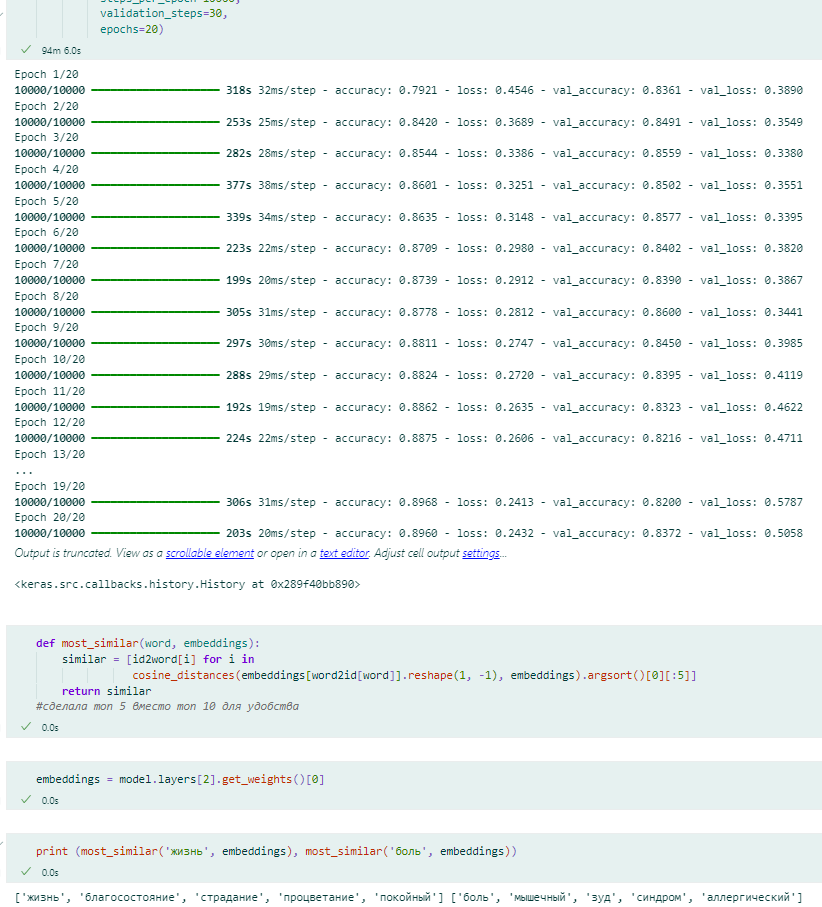

In [28]:
#cbow negative sampling
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(10,))


embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Lambda(lambda x: x.sum(axis=1))(embeddings_context)
dot = keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
model.build([(None, 1), (None, 10)])
model.fit(gen_batches_cbow(sentences[:19000], window=20),
          validation_data=gen_batches_cbow(sentences[19000:],  window=10),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=20)

RuntimeError: Unable to automatically build the model. Please build it yourself before calling fit/evaluate/predict. A model is 'built' when its variables have been created and its `self.built` attribute is True. Usually, calling the model on a batch of data is the right way to build it.
Exception encountered:
'Input 1 of layer "functional_2" is incompatible with the layer: expected shape=(None, 10), found shape=(1000, 20)'

# Задание 2 (2 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

# Задание 3 (3 балла)

Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.   
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)  
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор. 
В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)  
F1 мера должна быть выше 20%. 

# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.